In [1]:
import cv2
import numpy as np
import tensorflow as tf
import time
from yolov4.tf import YOLOv4

yolo = YOLOv4()
yolo.classes = "coco.names"
yolo.make_model()
yolo.load_weights("yolov4.weights", weights_type="yolo")

In [2]:
# original_image == Dim(height, width, channels)
original_image = cv2.imread("kite.jpg")
# resized_image == Dim(input_size, input_size, channels)
resized_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
resized_image = yolo.resize_image(resized_image)
# 0 ~ 255 to 0.0 ~ 1.0
resized_image = resized_image / 255
# input_data == Dim(1, input_size, input_size, channels)
input_data = resized_image[np.newaxis, ...].astype(np.float32)

In [7]:
start_time = time.time()
# x_pred == Dim(1, output_size, output_size, anchors, (bbox))
candidates = yolo.model.predict(input_data)

_candidates = []
for candidate in candidates:
    batch_size = candidate.shape[0]
    grid_size = candidate.shape[1]
    _candidates.append(
        tf.reshape(
            candidate, shape=(1, grid_size * grid_size * 3, -1)
        )
    )
# candidates == Dim(batch, candidates, (bbox))
candidates = np.concatenate(_candidates, axis=1)

pred_bboxes = yolo.candidates_to_pred_bboxes(candidates[0])
pred_bboxes = yolo.fit_pred_bboxes_to_original(
    pred_bboxes, original_image.shape
)
exec_time = time.time() - start_time
print("time: {:.2f} ms".format(exec_time * 1000))

time: 582.20 ms


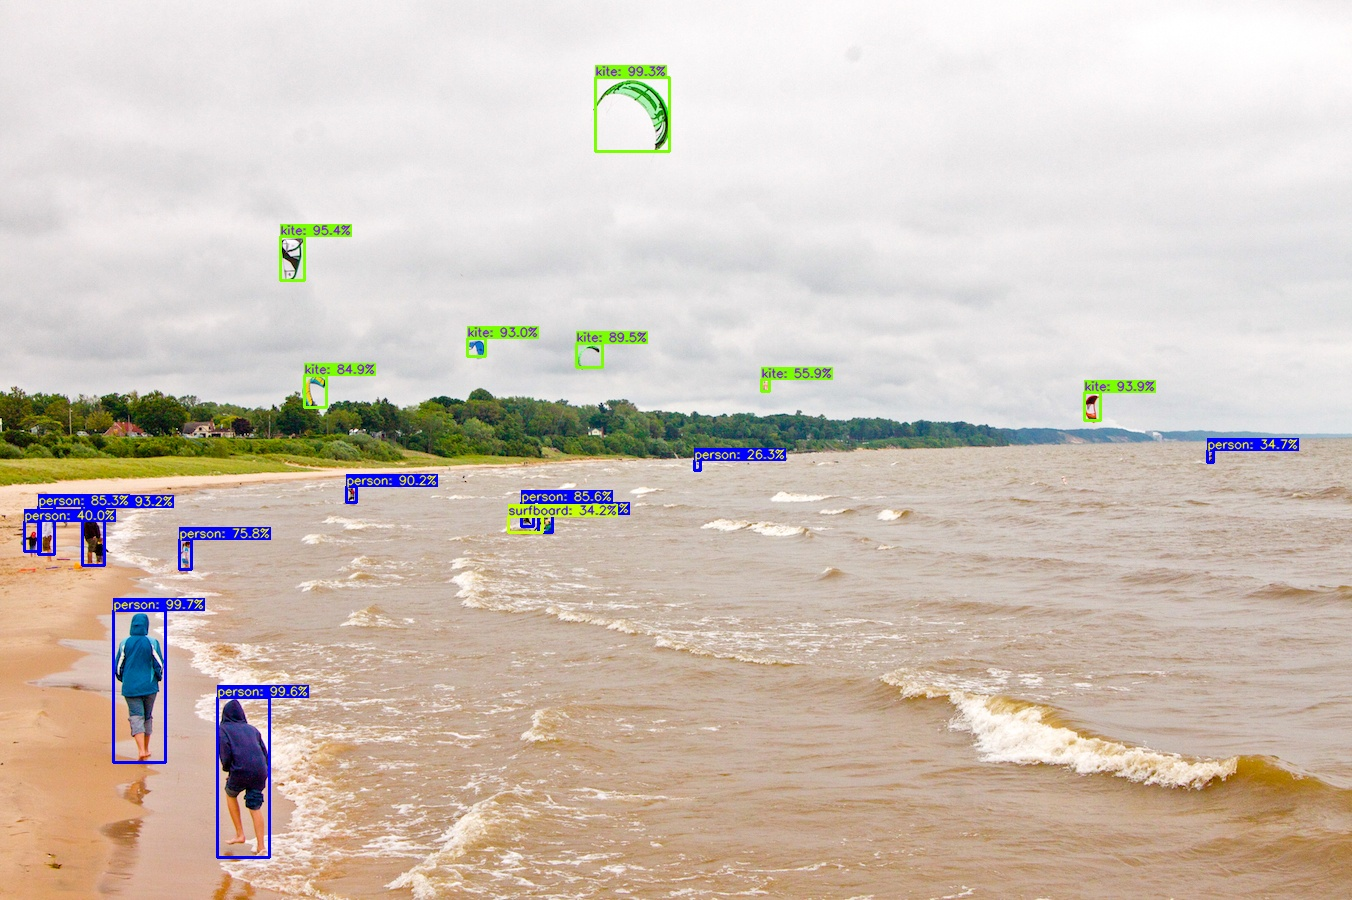

In [8]:
result = yolo.draw_bboxes(original_image, pred_bboxes)
cv2.imwrite("result.jpg", result) 
from IPython.display import Image
Image("result.jpg")